In [2]:
import numpy as np
import pandas as pd
from matplotlib import gridspec
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [3]:
EZ = fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.data.fits')
catalog = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                    format = 'ascii').to_pandas()
masterlist = pd.read_pickle('../phot/master_template_list.pkl')

In [4]:
def Phot_get(field, galaxy_id, masterlist, catalog):
    cat = catalog[catalog.id == galaxy_id]
    
    if field == 'GSD':
        pre= 'S_'

    if field == 'GND':
        pre= 'N_'

    eff_wv = []
    phot_fl = []
    phot_er = []
    phot_num = []

    for i in cat.keys():
        if i[0:2] == 'f_':
            Clam = 3E18 / masterlist.eff_wv[masterlist.tmp_name == pre + i].values[0] **2 * 10**((-1.1)/2.5-29)
            if cat[i].values[0] > -99.0:
                eff_wv.append(masterlist.eff_wv[masterlist.tmp_name == pre + i].values[0])
                phot_fl.append(cat[i].values[0]*Clam)
                phot_num.append(masterlist.tmp_num[masterlist.tmp_name == pre + i].values[0])
        if i[0:2] == 'e_':
            if cat[i].values[0] > -99.0:
                phot_er.append(cat[i].values[0]*Clam)

    return np.array([eff_wv, phot_fl, phot_er])

def read_templates(wave, temps):
    templates = []

    for temp in temps:
        templ = Template(wave, temp)
        templ.set_fnu()
        templates.append(templ)

    return templates

class Template():
    def __init__(self,tempwv, tempflux):
        self.wave = tempwv
        self.flux = tempflux
        self.flux_fnu = None
        self.set_fnu()

    def set_fnu(self):
        self.flux_fnu = self.flux * self.wave**2 / 3.e18


def full_sed(z, coeffs, templates):
    TEMP =read_templates(template_wv,templates)                      
    NTEMP = len(TEMP)
    
    import astropy.units as u

    templ = TEMP
    tempflux = np.zeros((NTEMP, templ[0].wave.shape[0]))
    for i in range(NTEMP):
        tempflux[i, :] = templ[i].flux_fnu

    templz = templ[0].wave*(1+z)

    templf = np.dot(coeffs, tempflux)
    return templz, templf

In [5]:
templates = EZ['TEMPF'].data
template_wv = EZ['TEMPL'].data
coeffs = EZ['COEFFS'].data
zgrid = EZ['ZGRID'].data 
zchi2 = EZ['CHI2'].data

In [6]:
effwv, phot, phot_er = Phot_get('GSD', 39170, masterlist, catalog)

In [9]:
wv,fl = full_sed(1.02, coeffs[39169], templates)
fnu_factor = 10**(-0.4*(25.0+48.6))
flam_spec = 3.e18/wv**2*1E19

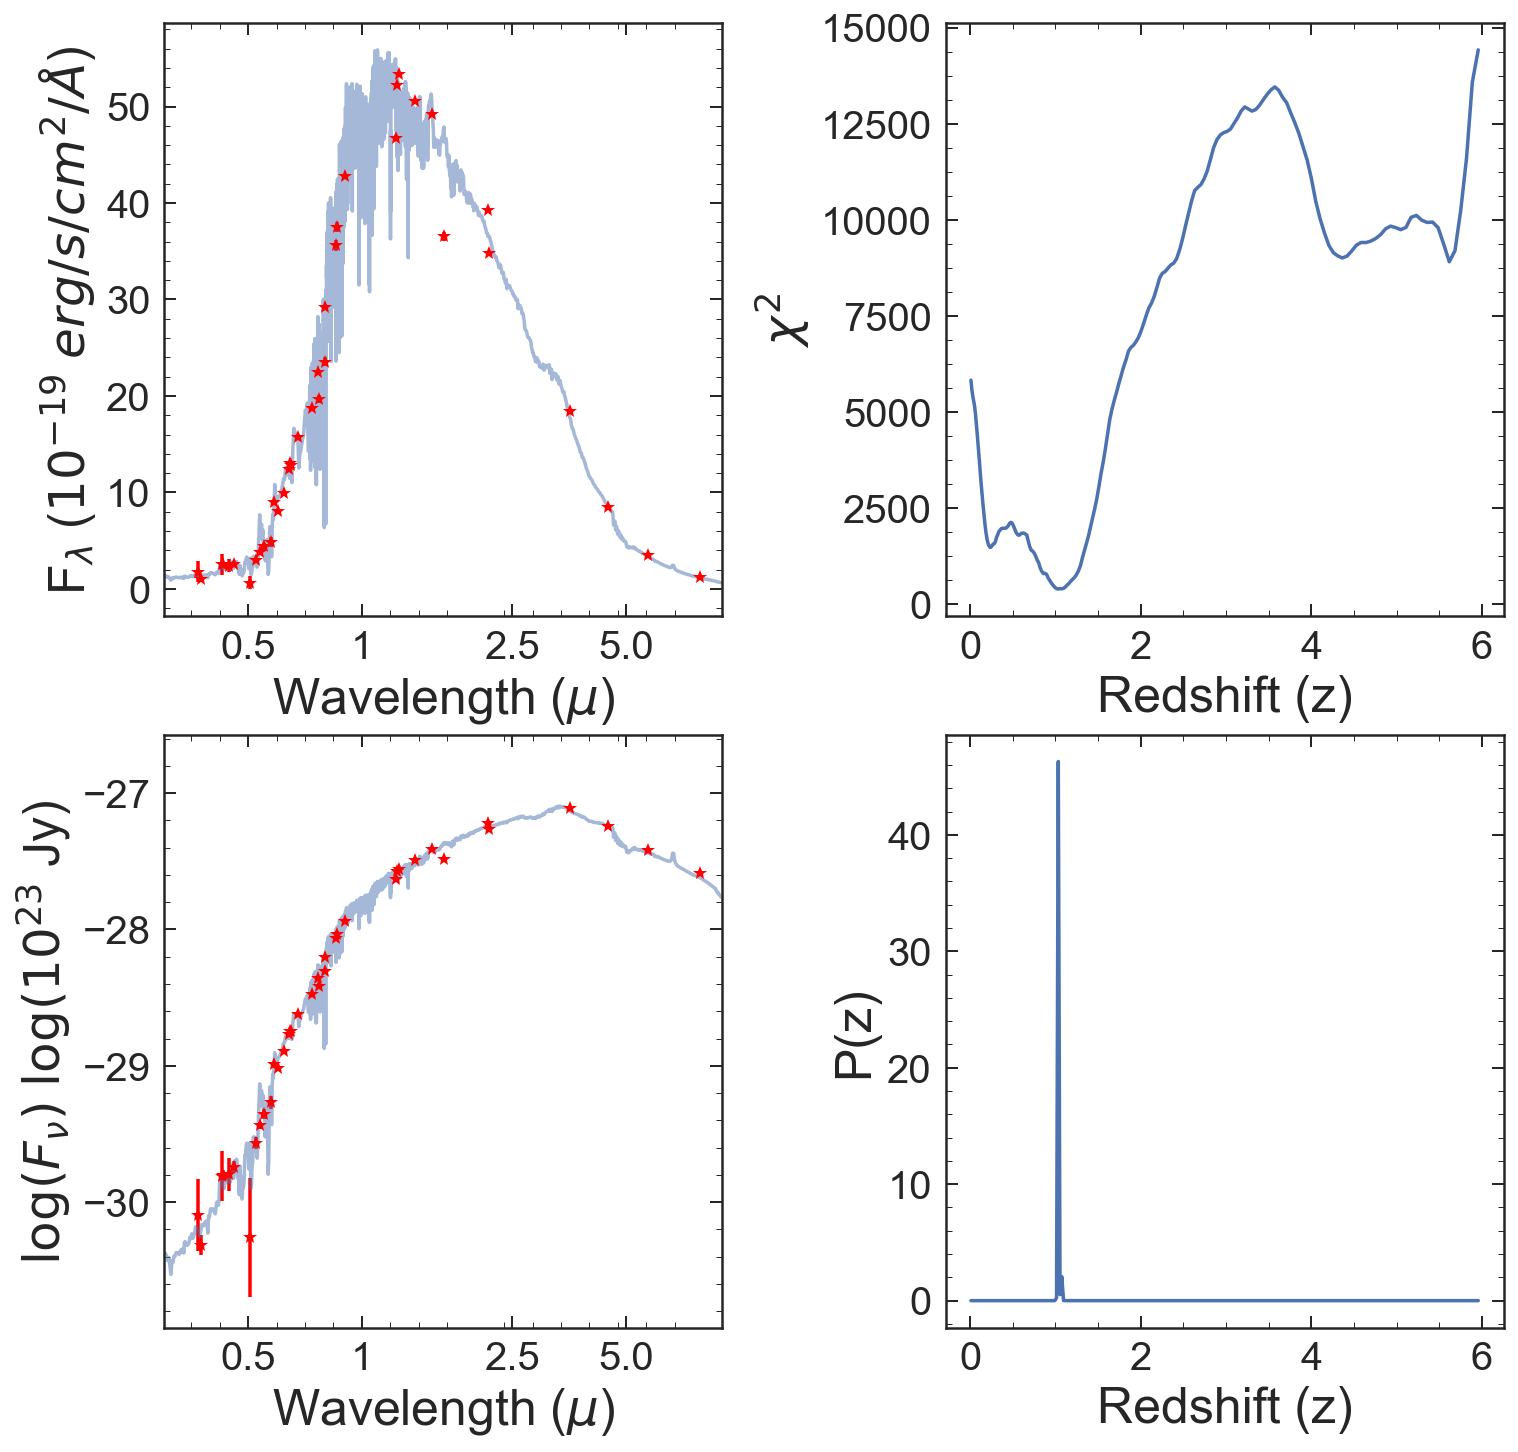

In [15]:
gs = gridspec.GridSpec(2,2, wspace=.4)

plt.figure(figsize = [12,12])
plt.subplot(gs[0,0])
plt.plot(np.log10(wv*1E-4),fl*fnu_factor*flam_spec, alpha=0.5)
plt.errorbar(np.log10(effwv*1E-4), phot*1E19, phot_er*1E19, color='r', marker = '*', linestyle = 'none')
plt.xticks(np.log10([0.5, 1, 2.5, 5.0]),[0.5, 1, 2.5, 5.0])

plt.xlabel('Wavelength ($\mu$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-19}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(np.log10(0.3),np.log10(9))

iscale = interp1d(wv,flam_spec)(effwv)
fnu = phot*1E19 / iscale
dfnu = phot_er*1E19/ iscale

plt.subplot(gs[1,0])
plt.plot(np.log10(wv*1E-4),np.log10(fl*fnu_factor), alpha=0.5)
plt.errorbar(np.log10(effwv*1E-4), np.log10(fnu), dfnu / (fnu * np.log(10)), color='r', marker = '*', linestyle = 'none')
plt.xticks(np.log10([0.5, 1, 2.5, 5.0]),[0.5, 1, 2.5, 5.0])

plt.xlabel('Wavelength ($\mu$)', fontsize=25)
plt.ylabel('$\log(F_\\nu)$ $\log(10^{23}$ Jy)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(np.log10(0.3),np.log10(9))
plt.ylim(min(np.log10(fnu))*1.02 , max(np.log10(fnu)) * 0.98)

plt.subplot(gs[0,1])
plt.plot(zgrid, zchi2[39169])
plt.xlabel('Redshift (z)', fontsize=25)
plt.ylabel('$\chi^2$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(gs[1,1])
P = np.exp( - np.array(zchi2[39169]).astype(np.float128) / 2)
P /= np.trapz(P,zgrid)

plt.plot(zgrid, P)
plt.xlabel('Redshift (z)', fontsize=25)
plt.ylabel('P(z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/example_eazyplot.png')

In [1]:
print(min(np.log10(fnu)), max(np.log10(fnu)))

NameError: name 'np' is not defined

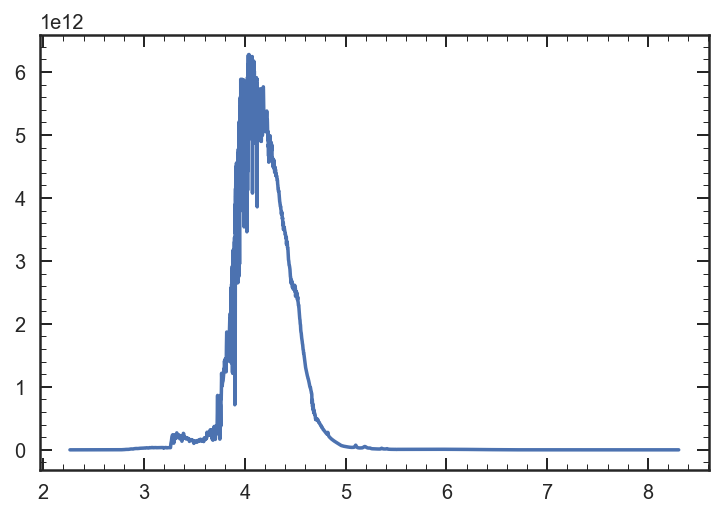

In [40]:
# plt.plot(np.log10(template_wv*(1+1.02)), to_flam(template_wv, bestfit))
plt.plot(np.log10(template_wv*(1+1.02)), bestfit)

# plt.errorbar(np.log10(effwv), phot, phot_er, marker = '*', linestyle = 'none')